In [ ]:
# 🏥 Predicting Patient Satisfaction with Hospital Beds Management Dataset

本 Notebook 使用 Kaggle「Hospital Beds Management」資料集，
以醫院營運指標預測 `patient_satisfaction`。

模型比較：
- Linear Regression（Baseline）
- Random Forest Regressor（非線性樹模型）

並分析：
- 效能指標：MAE、RMSE、R²
- Feature Importance（找出影響滿意度的關鍵指標）


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt


In [3]:
# 假設 Notebook 跟 data 資料夾同一層
data_path = "/content/services_weekly.csv"

df = pd.read_csv(data_path)
df.head()

,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event
0,1,1,emergency,32,76,32,44,67,70,none
1,1,1,surgery,45,130,45,85,83,78,flu
2,1,1,general_medicine,37,201,37,164,97,43,flu
3,1,1,ICU,22,31,22,9,84,91,flu
4,2,1,emergency,28,169,28,141,75,64,none


In [4]:
df.shape, df.info()
df.describe()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   week                  208 non-null    int64 
 1   month                 208 non-null    int64 
 2   service               208 non-null    object
 3   available_beds        208 non-null    int64 
 4   patients_request      208 non-null    int64 
 5   patients_admitted     208 non-null    int64 
 6   patients_refused      208 non-null    int64 
 7   patient_satisfaction  208 non-null    int64 
 8   staff_morale          208 non-null    int64 
 9   event                 208 non-null    object
dtypes: int64(8), object(2)
memory usage: 16.4+ KB


,0
week,0
month,0
service,0
available_beds,0
patients_request,0
patients_admitted,0
patients_refused,0
patient_satisfaction,0
staff_morale,0
event,0


In [5]:
# 使用的特徵欄位（依照 dataset 實際欄位為準）
feature_cols = [
    "available_beds",
    "patients_request",
    "patients_admitted",
    "patients_refused",
    "staff_morale",
]

target_col = "patient_satisfaction"

X = df[feature_cols]
y = df[target_col]

X.head()


,available_beds,patients_request,patients_admitted,patients_refused,staff_morale
0,32,76,32,44,70
1,45,130,45,85,78
2,37,201,37,164,43
3,22,31,22,9,91
4,28,169,28,141,64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((166, 5), (42, 5))

In [8]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("=== Linear Regression ===")
print(f"MAE : {mae_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²  : {r2_lr:.4f}")

=== Linear Regression ===
MAE : 8.9753
RMSE: 10.6345
R²  : 0.0043


In [11]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Random Forest ===")
print(f"MAE : {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²  : {r2_rf:.4f}")

=== Random Forest ===
MAE : 8.3464
RMSE: 10.4476
R²  : 0.0390


In [12]:
results = pd.DataFrame({
    "model": ["Linear Regression", "Random Forest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf],
})

results

,model,MAE,RMSE,R2
0,Linear Regression,8.975277,10.634504,0.004335
1,Random Forest,8.346429,10.447590,0.039027


In [13]:
importances = rf.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df


,feature,importance
4,staff_morale,0.285049
0,available_beds,0.200281
2,patients_admitted,0.195158
1,patients_request,0.160974
3,patients_refused,0.158537


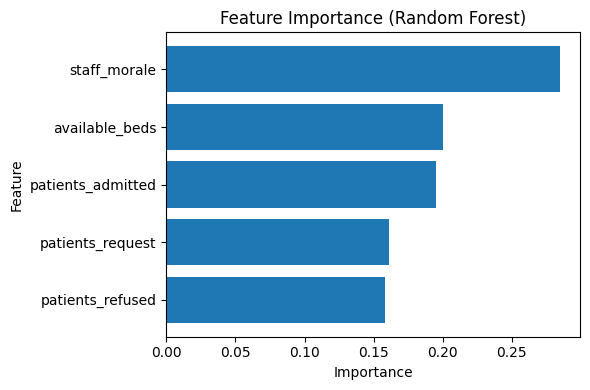

In [14]:
plt.figure(figsize=(6, 4))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=120,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("=== XGBoost ===")
print(f"MAE : {mae_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²  : {r2_xgb:.4f}")


TypeError: got an unexpected keyword argument 'squared'